# Tutorial 4 - Adaptive State Transition

Having tackled three basic types of problems in the first tutorials, we proceed with a more advanced concept relevant to KANs: grid updates. KANs provide the option of gradually increasing the size of the underlying grid as a fine-graining process. More theoretical details on this can be found [here](https://arxiv.org/abs/2404.19756) or [here](https://ieeexplore.ieee.org/document/10763509). In this notebook, we showcase how jaxKAN allows an adaptive state transition, introduced in [Adaptive Training of Grid-Dependent Physics-Informed Kolmogorov-Arnold Networks](https://ieeexplore.ieee.org/document/10763509), for an example of curve fitting.

In [1]:
import os
import sys

# Workaround to import jaxKAN
project_root = os.path.abspath("..")
sys.path.append(project_root)

from jaxkan.KAN import KAN
from jaxkan.utils.general import adam_transition

import jax
import jax.numpy as jnp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

## Data Generation

We will attempt to fit the multivariate function

$$ f(x_1, x_2, x_3, x_4) = \exp\left[\frac{1}{2}\sin\left(\pi x_1^2 + \pi x_2^2\right) + \frac{1}{2}\sin\left(\pi x_3^2 + \pi x_4^2\right)\right] $$

To this end, we will sample 4000 points from this function in the $[-1,1]^4$ domain to use for training and testing.

In [2]:
def f(x1,x2,x3,x4):
    return jnp.exp(0.5*jnp.sin((jnp.pi * x1**2) + (jnp.pi * x2**2)) + 0.5*jnp.sin((jnp.pi * x3**2) + (jnp.pi * x4**2)))

def generate_data(minval=-1, maxval=1, num_samples=1000, seed=42):
    key = jax.random.PRNGKey(seed)
    x1_key, x2_key, x3_key, x4_key = jax.random.split(key, 4)

    x1 = jax.random.uniform(x1_key, shape=(num_samples,), minval=minval, maxval=maxval)
    x2 = jax.random.uniform(x2_key, shape=(num_samples,), minval=minval, maxval=maxval)
    x3 = jax.random.uniform(x3_key, shape=(num_samples,), minval=minval, maxval=maxval)
    x4 = jax.random.uniform(x4_key, shape=(num_samples,), minval=minval, maxval=maxval)

    y = f(x1, x2, x3, x4).reshape(-1, 1)
    X = jnp.stack([x1, x2, x3, x4], axis=1)
    
    return X, y

In [3]:
seed = 42

X, y = generate_data(minval=-1, maxval=1, num_samples=4000, seed=seed)

## Preprocessing

We split the data into train/test sets.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (3200, 4)
Test set size: (800, 4)


## KAN Model

To showcase the adaptive state transition, we will use the Base KAN Layer, which corresponds to the original implementation of KANs using B-Splines. For more details about the required parameters of this type of layer, refer to the API Documentation.

In [5]:
# Initialize a KAN model
n_in = X_train.shape[1]
n_out = y_train.shape[1]
n_hidden = 10

layer_dims = [n_in, n_hidden, n_out]

req_params = {'k': 3, 'G': 3, 'grid_e': 0.02}

model = KAN(layer_dims = layer_dims,
            layer_type = 'base',
            required_parameters = req_params,
            add_bias = True,
            rngs = nnx.Rngs(seed)
           )

## Training

The model will be trained for a total of 800 epochs with a constant learning rate of 0.06, starting with a grid of size $G = 3$. The grid will be extended to sizes $G \to 6 \to 10 \to 24$ during epochs 200, 400 and 600, respectively.

In [6]:
opt_type = optax.adam(learning_rate=0.06)

optimizer = nnx.Optimizer(model, opt_type)

grid_upds = {0 : 3, 200 : 6, 400 : 10, 600 : 24}

### Without Adaptive State Transition

We will first train the model without the adaptive state transition.

In [7]:
# Define train loop
@nnx.jit
def train_step(model, optimizer, X_train, y_train):

    def loss_fn(model):
        residual = model(X_train) - y_train
        loss = jnp.mean((residual)**2)

        return loss
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    
    return loss

We start training without performing the adaptive state transition technique and then plot the training losses and a final evaluation score to keep as reference.

In [8]:
# Initialize train_losses
num_epochs = 800
train_losses = jnp.zeros((num_epochs,))

for epoch in range(num_epochs):
    # Check if we're in an update epoch
    if epoch in grid_upds.keys():
        print(f"Epoch {epoch}: Performing grid update")
        # Get grid size
        G_new = grid_upds[epoch]
        # Perform the update
        model.update_grids(X_train, G_new)
        # Reset optimizer
        optimizer = nnx.Optimizer(model, opt_type)
        
    # Calculate the loss
    loss = train_step(model, optimizer, X_train, y_train)
    
    # Append the loss
    train_losses = train_losses.at[epoch].set(loss)

Epoch 0: Performing grid update
Epoch 200: Performing grid update
Epoch 400: Performing grid update
Epoch 600: Performing grid update


First, let's evaluate the model.

In [9]:
y_pred = model(X_test)
mse = mean_squared_error(y_pred, y_test)

print(f"The MSE of the fit is {mse:.5f}")

The MSE of the fit is 0.00206


Now, let's visualize the training loss during training.

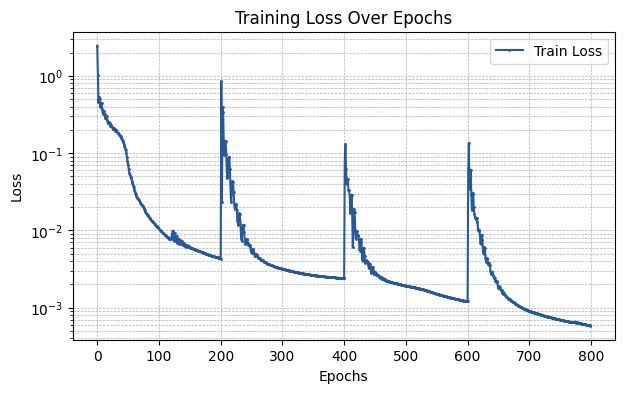

In [10]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

We notice abrupt peaks on the epochs during which we perform an extension of the grid.

### With Adaptive State Transition

We will now repeat the process, but also incorporate the adaptive state transition technique using the `adam_transition` method from `jaxkan.utils.general`.

In [11]:
# Re-initialize the model
model = KAN(layer_dims = layer_dims,
            layer_type = 'base',
            required_parameters = req_params,
            add_bias = True,
            rngs = nnx.Rngs(seed)
           )

# Re-initialize the optimizer
optimizer = nnx.Optimizer(model, opt_type)

In [12]:
# Initialize train_losses
train_losses = jnp.zeros((num_epochs,))

for epoch in range(num_epochs):
    # Check if we're in an update epoch
    if epoch in grid_upds.keys():
        print(f"Epoch {epoch}: Performing grid update")
        # Get grid size
        G_new = grid_upds[epoch]
        # Perform the update
        model.update_grids(X_train, G_new)
        # Instead of simply resetting the optimizer, we perform the update
        # -----------------------------------------------------------------
        # First, we get the new model's state
        _, model_state = nnx.split(model)
        # Then we pass the optimizer's state to the method
        old_state = optimizer.opt_state
        adam_transition(old_state, model_state)
        # -----------------------------------------------------------------
        
    # Calculate the loss
    loss = train_step(model, optimizer, X_train, y_train)
    
    # Append the loss
    train_losses = train_losses.at[epoch].set(loss)

Epoch 0: Performing grid update
Epoch 200: Performing grid update
Epoch 400: Performing grid update
Epoch 600: Performing grid update


Let's evaluate this version of the model.

In [13]:
y_pred = model(X_test)
mse = mean_squared_error(y_pred, y_test)

print(f"The MSE of the fit is {mse:.5f}")

The MSE of the fit is 0.00119


It appears that the final MSE is lower than the corresponding MSE from the previous case.

Let's also visualize the corresponding training loss curve.

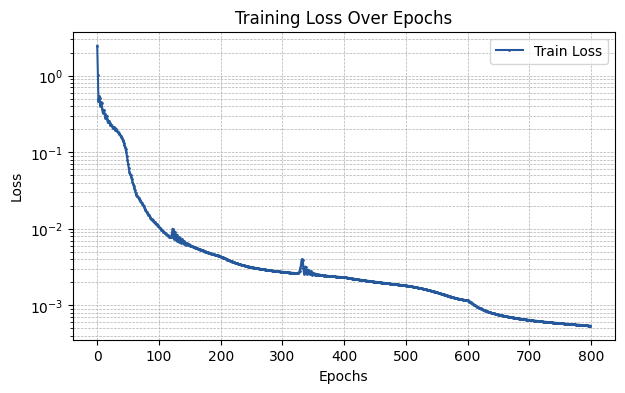

In [14]:
plt.figure(figsize=(7, 4))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

The spikes have disappeared.

**NOTE**: This is an effect that is heavily dependent on the chosen grid sizes as well as the learning rate, so the adaptive update might not always work "out of the box" as in this case. In other cases, the user may also need to experiment with learning rate schedulers or different grid size configurations 